## Business Problem Statement 

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. 
In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.


## Business Objective

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. 

Here we will analyze customer-level data of a leading telecom firm, and build predictive models to identify customers at high risk of churn.

### The solution is divided into the following sections:

- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import missingno as msno
%matplotlib inline


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-churn-case-study-hackathon-cc50/data_dictionary.csv
/kaggle/input/telecom-churn-case-study-hackathon-cc50/sample.csv
/kaggle/input/telecom-churn-case-study-hackathon-cc50/train.csv
/kaggle/input/telecom-churn-case-study-hackathon-cc50/test.csv


In [3]:
# Reading All input data available in input directory for Data Understanding
telecom_data = pd.read_csv("../input/telecom-churn-case-study-hackathon-cc50/train.csv")
telecom_test = pd.read_csv("../input/telecom-churn-case-study-hackathon-cc50/test.csv")
telecom_sample = pd.read_csv("../input/telecom-churn-case-study-hackathon-cc50/sample.csv")
telecom_data_dict = pd.read_csv("../input/telecom-churn-case-study-hackathon-cc50/data_dictionary.csv")

print(telecom_data.shape)
print(telecom_test.shape)
print(telecom_sample.shape)
print(telecom_data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


## Understanding Data Dictionary and Train data

1. We found that data is available for 3 months : June(6),July(7) and August(8)
2. We found that following are distinct columns and their high level understanding:
- arpu_<2g,3g,No Value>_<6,7,8> : Average revenue per user <2,3> G Network for month <6,7,8>
- loc_ic_t2f_mou_<6,7,8> : Local calls  within same telecom circle Operator T to fixed lines of T Minutes of usage  voice calls for month <6,7,8>
- loc_ic_t2m_mou_<6,7,8> : Local calls  within same telecom circle Operator T to other operator mobile Minutes of usage  voice calls for month <6,7,8>
- loc_ic_t2o_mou_<6,7,8> : Local calls  within same telecom circle Operator Operator T to other operator fixed line Minutes of usage  voice calls for month <6,7,8>
- loc_og_t2c_mou_<6,7,8> : Local calls  within same telecom circle Operator Operator T to its own call center Minutes of usage  voice calls for month <6,7,8>


In [4]:
telecom_data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [5]:
# Checking dup;licate rows in data 
print("Duplicate rows : ",telecom_data.duplicated().sum())#0 duplicate rows

Duplicate rows :  0


In [6]:
#Checking the percentage of missing values column-wise

((telecom_data.isnull().sum()/ len(telecom_data)) * 100).sort_values(False)

id                     0.000000
last_day_rch_amt_8     0.000000
last_day_rch_amt_7     0.000000
last_day_rch_amt_6     0.000000
max_rech_amt_8         0.000000
                        ...    
count_rech_2g_6       74.902499
count_rech_3g_6       74.902499
arpu_2g_6             74.902499
total_rech_data_6     74.902499
max_rech_data_6       74.902499
Length: 172, dtype: float64

### Insights:
From the above percentages we can see that there are columns which have more than 70% of data missing. We can drop these columns as they would convey a very little information.

But we have to take care of these columns so that we do not drop important  columns like : total recharge amount,average recharge amount.Example:

total_rech_data_6 - 74.8467 % missing values
total_rech_data_7 - 74.4287 % missing values
av_rech_amt_data_6 - 74.8467 % missing values
av_rech_amt_data_7 - 74.4287 % missing values
We have 2 more columns as -

date_of_last_rech_data_6 - 74.8467 % missing values
date_of_last_rech_data_7 - 74.4287 % missing values
Lets see how we can impute the missing values in the above mentioned columns.

In [7]:
# In ideal scenerio total_rech_data_6 and date_of_last_rech_data_6 should have  both 
# null values at the same index which means there was no data recharge done for that month
# and we can safely impute the 'total_rech_data_6' value with 0.

total_rech_data_6_index = telecom_data['total_rech_data_6'].isnull()
date_of_last_rech_data_6_index = telecom_data['date_of_last_rech_data_6'].isnull()

if total_rech_data_6_index.equals(date_of_last_rech_data_6_index):
    print('The index for NULL values matches for month 6')

The index for NULL values matches for month 6


#### Insights:
We see that non-matching of indexes was not found in 'total_rech_data_6' and date_of_last_rech_data_6. So missing values can be imputed with 0. we can impute 0 for 'av_rech_amt_data_6'.

In [8]:
telecom_data['total_rech_data_6'].fillna(0, inplace=True)
telecom_data['av_rech_amt_data_6'].fillna(0, inplace=True)

Following same approach for : total_rech_data_7,av_rech_amt_data_7, total_rech_data_8,av_rech_amt_data_8

In [9]:
total_rech_data_7_index = telecom_data['total_rech_data_7'].isnull()
date_of_last_rech_data_7_index = telecom_data['date_of_last_rech_data_7'].isnull()

if total_rech_data_7_index.equals(date_of_last_rech_data_7_index):
    print('The index for NULL values matches for month 7')

The index for NULL values matches for month 7


In [10]:
telecom_data['total_rech_data_7'].fillna(0, inplace=True)
telecom_data['av_rech_amt_data_7'].fillna(0, inplace=True)

In [11]:
total_rech_data_8_index = telecom_data['total_rech_data_8'].isnull()
date_of_last_rech_data_8_index = telecom_data['date_of_last_rech_data_8'].isnull()

if total_rech_data_8_index.equals(date_of_last_rech_data_8_index):
    print('The index for NULL values matches for month 8')

The index for NULL values matches for month 8


In [12]:
telecom_data['total_rech_data_8'].fillna(0, inplace=True)
telecom_data['av_rech_amt_data_8'].fillna(0, inplace=True)

In [13]:
#Checking the percentage of missing values column-wise

((telecom_data.isnull().sum()/ len(telecom_data)) * 100).sort_values(False)
telecom_data.shape

(69999, 172)

In [14]:
# Checking how many columns have more than 40% data missing.

total_cols_with_atleast_40_percent_missing_data = ((telecom_data.isnull().sum()/ len(telecom_data)) * 100) >= 40
total_cols_with_atleast_40_percent_missing_data.sum()

24

In [15]:
# Get the column/feature names which have more than 40% missing data.

cols_names_with_40_percent_missing_value = total_cols_with_atleast_40_percent_missing_data[
    total_cols_with_atleast_40_percent_missing_data > 0.40].index

cols_names_with_40_percent_missing_value

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8'],
      dtype='object')

In [16]:
#Date columns with 40% missing values will not have any meaning and hence they can be easilyd dropped

telecom_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace = True)

In [17]:
# Max values column having missing values can be imputed with 0

for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    telecom_data[col].fillna(0, inplace=True)

We have been observing that all the misssing values are from the same record i.e., say for example the column for **max_rech_data_** for a particular month is missing then all the other attributes related to mobile internet are also missing. So every attribute can be imputed with 0.

In [18]:
# Let's impute the missing values with 0

columns_to_impute = ['count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

telecom_data[columns_to_impute] = telecom_data[columns_to_impute].fillna(0)

In [19]:
telecom_data[columns_to_impute].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   count_rech_2g_6   69999 non-null  float64
 1   count_rech_2g_7   69999 non-null  float64
 2   count_rech_2g_8   69999 non-null  float64
 3   count_rech_3g_6   69999 non-null  float64
 4   count_rech_3g_7   69999 non-null  float64
 5   count_rech_3g_8   69999 non-null  float64
 6   arpu_3g_6         69999 non-null  float64
 7   arpu_3g_7         69999 non-null  float64
 8   arpu_3g_8         69999 non-null  float64
 9   arpu_2g_6         69999 non-null  float64
 10  arpu_2g_7         69999 non-null  float64
 11  arpu_2g_8         69999 non-null  float64
 12  night_pck_user_6  69999 non-null  float64
 13  night_pck_user_7  69999 non-null  float64
 14  night_pck_user_8  69999 non-null  float64
 15  fb_user_6         69999 non-null  float64
 16  fb_user_7         69999 non-null  float6

In [20]:
# Let's check on the date values
date_columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 
                'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']

telecom_data[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_of_last_rech_6   68898 non-null  object
 1   date_of_last_rech_7   68765 non-null  object
 2   date_of_last_rech_8   67538 non-null  object
 3   last_date_of_month_6  69999 non-null  object
 4   last_date_of_month_7  69600 non-null  object
 5   last_date_of_month_8  69266 non-null  object
dtypes: object(6)
memory usage: 3.2+ MB


In [21]:
# Removing date columns
telecom_data.drop(date_columns, axis=1, inplace = True)

In [22]:
telecom_data.shape

(69999, 163)

In [23]:
columns_with_null_values = telecom_data.columns[telecom_data.isna().any()].tolist()
print(columns_with_null_values)
print(telecom_data.isnull().sum())

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_m

In [24]:
for column in columns_with_null_values:
        telecom_data[column].fillna(0, inplace=True)

In [25]:
columns_with_null_values = telecom_data.columns[telecom_data.isna().any()].tolist()
print(columns_with_null_values)
print(telecom_data.isnull().sum())

[]
id                   0
circle_id            0
loc_og_t2o_mou       0
std_og_t2o_mou       0
loc_ic_t2o_mou       0
                    ..
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
churn_probability    0
Length: 163, dtype: int64


In [26]:
# Dropping columns as total columns exists for them
individual_cols = ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
                   'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
                   'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
                   'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
                   'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
                   'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
                   'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                   'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                   'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
                   'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
                   'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
                   'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
                   'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
                   'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
                   'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
                   'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
                   'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

telecom_data.drop(individual_cols, axis = 1, inplace = True)

telecom_data.shape

(69999, 112)

In [27]:
# Removing columns with 0 variance
columns_with_0_variance = telecom_data.var() == 0
print("Total columns with ZERO variance are - ", columns_with_0_variance.sum())

column_name_with_0_variance = columns_with_0_variance[columns_with_0_variance == 1].index
print(column_name_with_0_variance)

print("\n------------------------------------------------------------------------------\n")


Total columns with ZERO variance are -  10
Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

------------------------------------------------------------------------------



In [28]:
# Dropping the non - date columns 

telecom_data.drop(column_name_with_0_variance, axis=1, inplace = True)

In [29]:
telecom_data.shape

(69999, 102)

In [30]:
#Deleting negative arpu values

telecom_data = telecom_data[(telecom_data['arpu_6'] >= 0) & 
                            (telecom_data['arpu_7'] >= 0) & 
                            (telecom_data['arpu_8'] >= 0)]

In [31]:
telecom_data.shape

(69022, 102)

## Step 3: Exploratory Data analysis

In [32]:
# These variables have 0 or 1 as values 
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

telecom_data[category_list] = telecom_data[category_list].astype(int)

telecom_data[category_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69022 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   night_pck_user_6  69022 non-null  int64
 1   night_pck_user_7  69022 non-null  int64
 2   night_pck_user_8  69022 non-null  int64
 3   fb_user_6         69022 non-null  int64
 4   fb_user_7         69022 non-null  int64
 5   fb_user_8         69022 non-null  int64
dtypes: int64(6)
memory usage: 3.7 MB


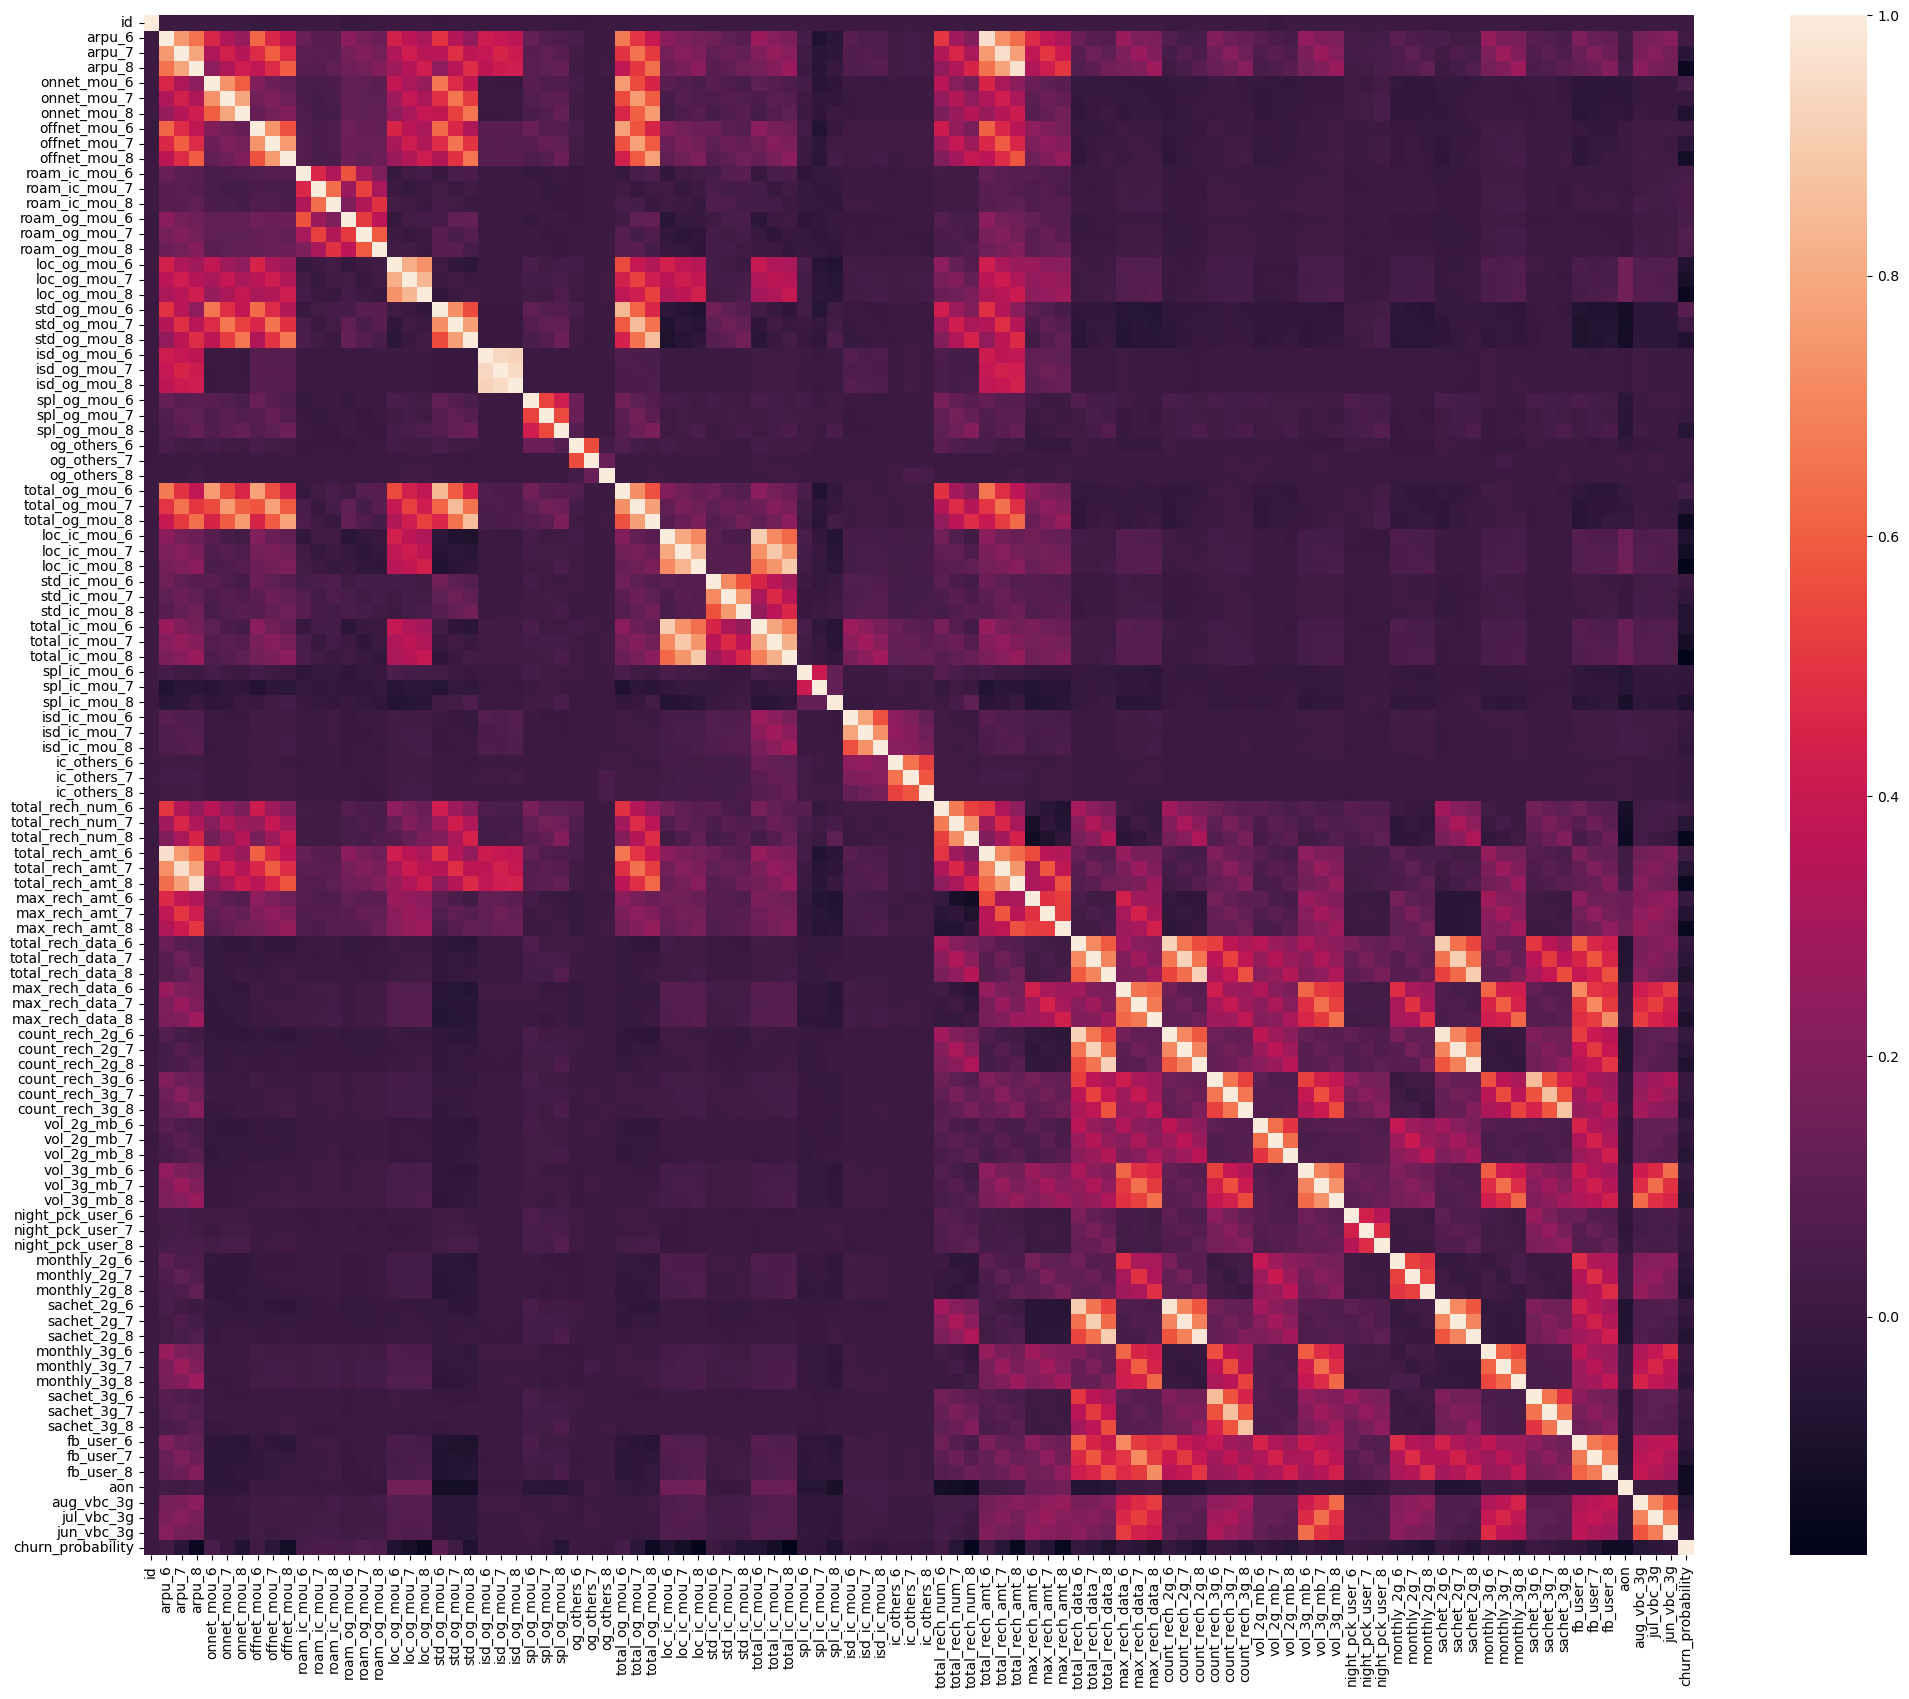

In [33]:
plt.figure(figsize = (25, 20))

sns.heatmap(telecom_data.corr())

plt.show()

In [34]:
# Listing out high corelated attributes
corr_matrix = telecom_data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
print("List of highly correlated features from the above plot - \n\n", highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(highly_correlated_features))

List of highly correlated features from the above plot - 

 ['loc_og_mou_7', 'loc_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


Total features with high correlation -  24


## Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [35]:
# To derive good phase columns and drop the original columns 
def derive_phase(df, col):
    
    col_6 = col + "_6"
    col_7 = col + "_7"
    col_8 = col + "_8"
    good_phase = col + "_good_phase"
    action_phase = col + "_action_phase"
    
    df[good_phase] = (df[col_6] + df[col_7])/2
    df[action_phase] = df[col_8] - df[good_phase]
    
    df.drop([col_6, col_7, col_8], axis = 1, inplace = True)
    
    return df

In [36]:
# Deriving Phase Attributes
telecom_data = derive_phase(telecom_data, "total_ic_mou")
telecom_data = derive_phase(telecom_data, "total_rech_num")
telecom_data = derive_phase(telecom_data, "total_rech_data")
telecom_data = derive_phase(telecom_data, "arpu")
telecom_data = derive_phase(telecom_data, "onnet_mou")
telecom_data = derive_phase(telecom_data, "offnet_mou")
telecom_data = derive_phase(telecom_data, "roam_ic_mou")
telecom_data = derive_phase(telecom_data, "roam_og_mou")
telecom_data = derive_phase(telecom_data, "loc_og_mou")
telecom_data = derive_phase(telecom_data, "std_og_mou")
telecom_data = derive_phase(telecom_data, "isd_og_mou")
telecom_data = derive_phase(telecom_data, "spl_og_mou")
telecom_data = derive_phase(telecom_data, "count_rech_2g")
telecom_data = derive_phase(telecom_data, "og_others")
telecom_data = derive_phase(telecom_data, "total_og_mou")
telecom_data = derive_phase(telecom_data, "loc_ic_mou")
telecom_data = derive_phase(telecom_data, "std_ic_mou")
telecom_data = derive_phase(telecom_data, "spl_ic_mou")
telecom_data = derive_phase(telecom_data, "isd_ic_mou")
telecom_data = derive_phase(telecom_data, "ic_others")
telecom_data = derive_phase(telecom_data, "max_rech_amt")
telecom_data = derive_phase(telecom_data, "max_rech_data")
telecom_data = derive_phase(telecom_data, "monthly_3g")
telecom_data = derive_phase(telecom_data, "sachet_3g")
telecom_data = derive_phase(telecom_data, "count_rech_3g")
telecom_data = derive_phase(telecom_data, "vol_2g_mb")
telecom_data = derive_phase(telecom_data, "vol_3g_mb")
telecom_data = derive_phase(telecom_data, "monthly_2g")
telecom_data = derive_phase(telecom_data, "sachet_2g")
telecom_data = derive_phase(telecom_data, "total_rech_amt")

In [37]:
telecom_data.head()

,id,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,...,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase,monthly_2g_good_phase,monthly_2g_action_phase,sachet_2g_good_phase,sachet_2g_action_phase,total_rech_amt_good_phase,total_rech_amt_action_phase
0,0,0,0,0,0,0,0,1958,0.0,0.0,...,0.000,0.000,0.00,0.00,0.0,0.0,0.0,0.0,71.0,-61.0
1,1,0,0,0,0,1,0,710,0.0,0.0,...,176.455,-176.455,1.98,-1.98,0.0,0.0,0.0,0.0,72.5,-22.5
2,2,0,0,0,0,0,0,882,0.0,0.0,...,0.000,0.000,0.00,0.00,0.0,0.0,0.0,0.0,95.0,-95.0
3,3,0,0,0,0,0,0,982,0.0,0.0,...,0.000,0.000,0.00,0.00,0.0,0.0,0.0,0.0,200.0,-70.0
4,4,0,0,0,1,1,1,647,0.0,0.0,...,349.845,-136.375,0.00,0.00,0.0,0.0,6.5,-0.5,213.0,-91.0


In [38]:
# Model Building
# Train and Test Split
X = telecom_data.iloc[:,:-1]
y = telecom_data.iloc[:,-1]

In [39]:
X.shape, y.shape

((69022, 71), (69022,))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(48315, 71)
(48315,)
(20707, 71)
(20707,)


In [41]:
# Data Normalisation : Outlier Handling
# Normalize the data
scaler = RobustScaler()

scaled_data = scaler.fit_transform(X_train)

X_train = pd.DataFrame(data = scaled_data, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

# Handling class imbalance using smote

In [42]:
# Implement SMOTEENN
def implement_smoteenn(X_train, y_train):
    
    sampling = SMOTEENN(random_state = 100)
    X_train_resampled, y_train_resampled = sampling.fit_resample(X_train.values, y_train.values.ravel())

    # Shuffle the data
    perms = np.random.permutation(X_train_resampled.shape[0])
    X_train_resampled = X_train_resampled[perms]
    y_train_resampled = y_train_resampled[perms]

    X_train_resampled = pd.DataFrame(data = X_train_resampled)
    y_train_resampled = pd.DataFrame(data = y_train_resampled)

    print(X_train_resampled.shape)
    print(y_train_resampled.shape)
    
    return X_train_resampled, y_train_resampled

In [43]:
# Applying Transformations
def apply_transformations(dataset, X_train, y_train):
    
    dataset.append(("base", X_train, y_train))
    
    dataset.append(transform(SMOTE(n_jobs = -1, random_state = 100), X_train, y_train))
    
    dataset.append(transform(RandomOverSampler(random_state = 100), X_train, y_train))
    
    dataset.append(transform(NearMiss(n_jobs = -1, random_state = 100), X_train, y_train))

    dataset.append(transform(RandomUnderSampler(random_state = 100), X_train, y_train))

    dataset.append(transform(SMOTEENN(random_state = 100), X_train, y_train))

    dataset.append(transform(SMOTETomek(random_state = 100), X_train, y_train))
    
    return dataset

In [44]:
# General Function to get scores
def get_scores(scores, reg, X_test):
    
    # Plot ROC and PR curves using all models and test data
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))

    pred_test = reg.predict(X_test.values)

    pred_test_probs = reg.predict_proba(X_test.values)[:, 1:]

    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), pred_test)
    p, r, t = precision_recall_curve(y_test.values.ravel(), pred_test_probs)

    model_f1_score = f1_score(y_test.values.ravel(), pred_test)
    model_precision_score = precision_score(y_test.values.ravel(), pred_test)
    model_recall_score = recall_score(y_test.values.ravel(), pred_test)
    model_accuracy_score = accuracy_score(y_test.values.ravel(), pred_test)
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(p, r, reorder = True)

    scores.append((model_f1_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr,
                   confusion_matrix(y_test.values.ravel(), pred_test)))

    axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(r, p, label = f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc = "lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("AUC ROC curve")

    axes[1].legend(loc = "lower right")
    axes[1].set_xlabel("recall")
    axes[1].set_ylabel("precision")
    axes[1].set_title("PR curve")

    plt.tight_layout()
    plt.show()
    
    return scores

# PCA - Dimensionality Reduction

In [45]:
def perform_PCA(X):
    
    pca = PCA(svd_solver = 'randomized', random_state = 100)

    #Doing the PCA on the train data
    pca.fit(X)
    
    # Making the screeplot - plotting the cumulative variance against the number of components
    fig = plt.figure(figsize = (12,8))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))

    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [46]:
def perform_incremental_PCA(X_train, y_train, components):
    
    # Using incremental PCA for efficiency - saves a lot of time on larger datasets

    pca_final = IncrementalPCA(n_components = components)

    X_train_pca = pca_final.fit_transform(X_train)
    X_test_pca = pca_final.transform(X_test)

    X_train_pca = pd.DataFrame(data = X_train_pca)
    X_test_pca = pd.DataFrame(data = X_test_pca)

    print(X_train_pca.shape)
    print(y_train.shape)
    print(X_test_pca.shape)
    print(y_test.shape)
    
    #creating correlation matrix for the principal components
    corrmat = np.corrcoef(X_train_pca.transpose())

    #plotting the correlation matrix
    plt.figure(figsize = (20,10))
    sns.heatmap(corrmat, annot = True)
    plt.show()
    
    # 1s -> 0s in diagonals
    corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
    print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
    # we see that correlations are indeed very close to 0
    
    return X_train_pca, X_test_pca

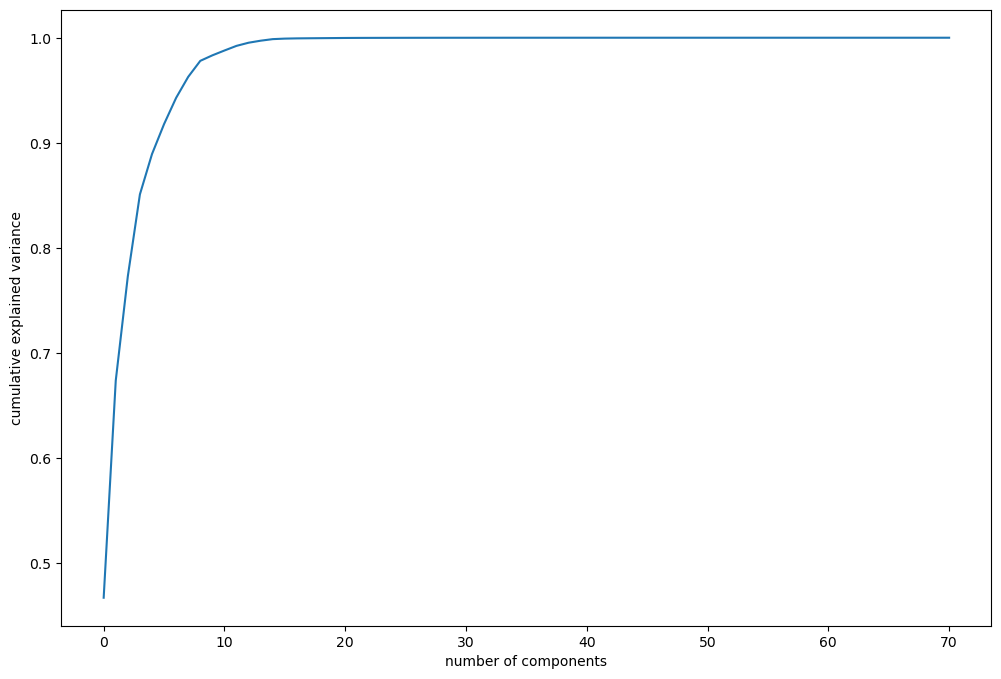

In [47]:
perform_PCA(X_train)

Selecting 5 components for modeling.

(48315, 5)
(48315,)
(20707, 5)
(20707,)


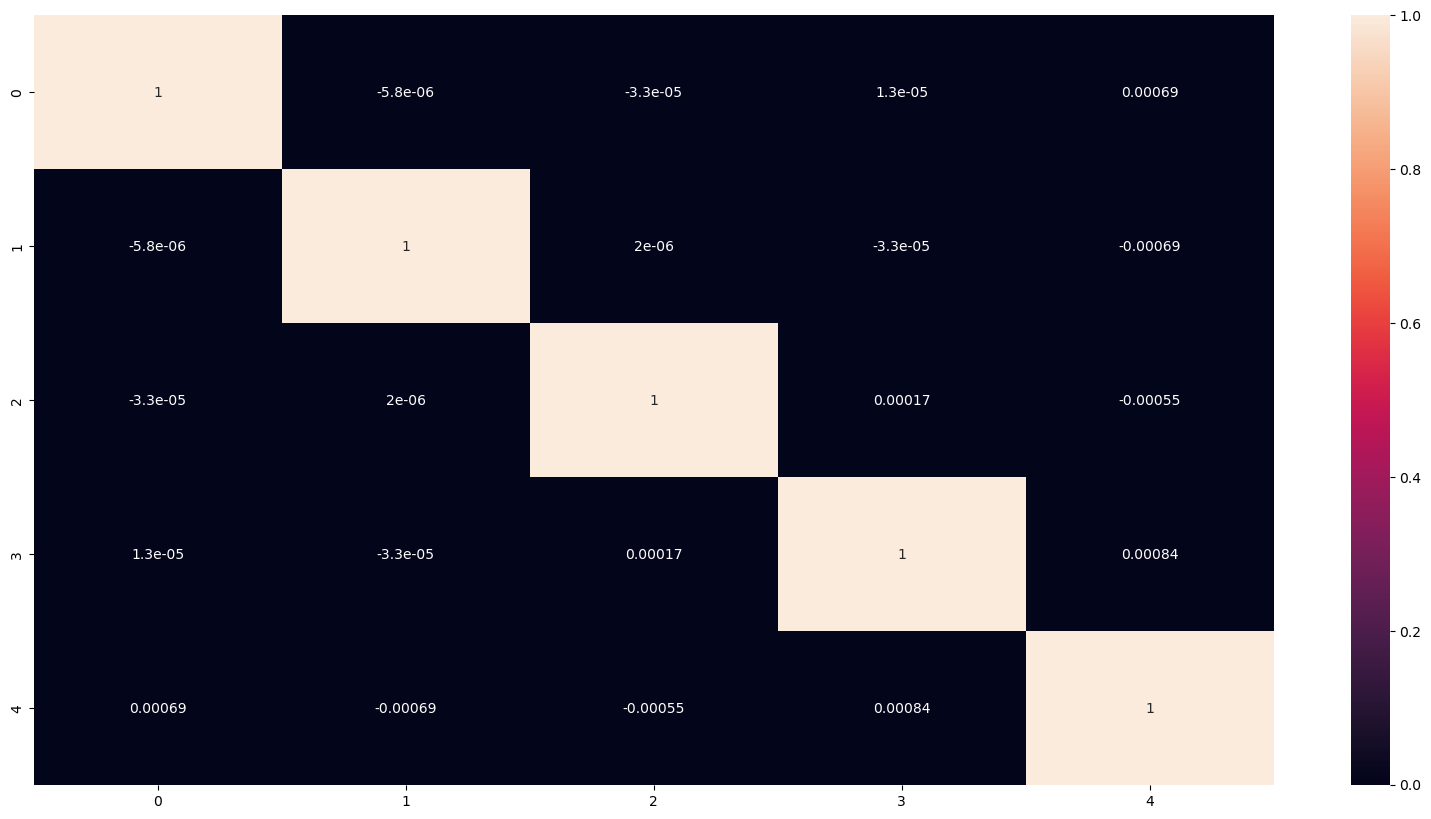

max corr: 0.0008370232888151141 , min corr:  -0.0006947740941717684


In [48]:
X_train_pca, X_test_pca = perform_incremental_PCA(X_train, y_train, 5)

*Handling Class Imbalance on PCA derived data*

In [49]:
max(telecom_data.dtypes)

dtype('float64')

In [50]:
# Implement SMOTEENN
X_train_resampled, y_train_resampled = implement_smoteenn(X_train_pca, y_train)

ValueError: Unknown label type: 'continuous'